In [1]:
import sys
import re
from collections import defaultdict

WAV_FILE_PATH = 'data/wav.root'

import uproot

import numpy as np
from matplotlib import pyplot as plt

# Load file

In [2]:
DATA_DIR = 'wav/CTPPS/TimingDiamond/sector 56/station 220cyl/cyl_hr'

In [3]:
file_raw = uproot.open(WAV_FILE_PATH)

len(file_raw)

75493

In [4]:
file_raw.keys()[:20]

['wav;1',
 'wav/CTPPS;1',
 'wav/CTPPS/TimingDiamond;1',
 'wav/CTPPS/TimingDiamond/sector 45;1',
 'wav/CTPPS/TimingDiamond/sector 45/station 220cyl;1',
 'wav/CTPPS/TimingDiamond/sector 45/station 220cyl/cyl_hr;1',
 'wav/CTPPS/TimingDiamond/sector 45/station 220cyl/cyl_hr/673942;1',
 'wav/CTPPS/TimingDiamond/sector 45/station 220cyl/cyl_hr/673942/ctpps_ti_diamond_45_220cyl_cyl_hr_0_11;1',
 'wav/CTPPS/TimingDiamond/sector 45/station 220cyl/cyl_hr/673942/ctpps_ti_diamond_45_220cyl_cyl_hr_0_11/fpgaTimestamp;1',
 'wav/CTPPS/TimingDiamond/sector 45/station 220cyl/cyl_hr/673942/ctpps_ti_diamond_45_220cyl_cyl_hr_0_11/timestampA;1',
 'wav/CTPPS/TimingDiamond/sector 45/station 220cyl/cyl_hr/673942/ctpps_ti_diamond_45_220cyl_cyl_hr_0_11/timestampB;1',
 'wav/CTPPS/TimingDiamond/sector 45/station 220cyl/cyl_hr/673942/ctpps_ti_diamond_45_220cyl_cyl_hr_0_11/cellInfo;1',
 'wav/CTPPS/TimingDiamond/sector 45/station 220cyl/cyl_hr/673942/ctpps_ti_diamond_45_220cyl_cyl_hr_0_11/cal;1',
 'wav/CTPPS/TimingDia

In [5]:
len(file_raw[DATA_DIR])

57357

In [6]:
sorted_events = sorted(file_raw[DATA_DIR].keys(recursive=False), key=lambda x: int(x[:-2]))
sorted_events[:20]

['3375;1',
 '6341;1',
 '7535;1',
 '8570;1',
 '9831;1',
 '9900;1',
 '10650;1',
 '11542;1',
 '13050;1',
 '14400;1',
 '15834;1',
 '15880;1',
 '17250;1',
 '17550;1',
 '18291;1',
 '19792;1',
 '20290;1',
 '22036;1',
 '23032;1',
 '24253;1']

# Produce dataset

In [7]:
class WaveformData:
    def __init__(self, series, fpga_timestamp, timestampA, timestampB, cell_info):
        self.series = series
        self.fpga_timestamp = fpga_timestamp
        self.timestampA = timestampA
        self.timestampB = timestampB
        self.cell_info = cell_info
        
    @classmethod
    def from_det_data(cls, det_data):
        series = np.array(det_data['cal'].values())
        fpga_timestamp = int(det_data['fpgaTimestamp'].members['fTitle'])
        timestampA = int(det_data['timestampA'].members['fTitle'])
        timestampB = int(det_data['timestampB'].members['fTitle'])
        cell_info = int(det_data['cellInfo'].members['fTitle'])
        return cls(series, fpga_timestamp, timestampA, timestampB, cell_info)

In [8]:
dataset = {}

for event in sorted_events:
    event_int = int(event[:-2])
    dataset[event_int] = {}
    event_data = file_raw[DATA_DIR][event]
    for det_name, det_data in event_data.items(recursive=False):
        dataset[event_int][det_name] = WaveformData.from_det_data(det_data)

In [9]:
dataset[3375]['ctpps_ti_diamond_56_220cyl_cyl_hr_1_11;1'].series.shape

(2, 24)

In [10]:
plane_hits = defaultdict(int)
for key, val in dataset.items():
    plane_hits[len(val)] += 1
    
plane_hits

defaultdict(int,
            {3: 995, 1: 716, 6: 106, 7: 122, 2: 445, 4: 482, 8: 70, 5: 97})

# Examples

In [11]:
events_to_view = []
for key, val in dataset.items():
    if len(val) == 4:
        events_to_view.append(key)
    if len(events_to_view) == 8:
        break
        
events_to_view

[19792, 24253, 28186, 29933, 49313, 54450, 54509, 57600]

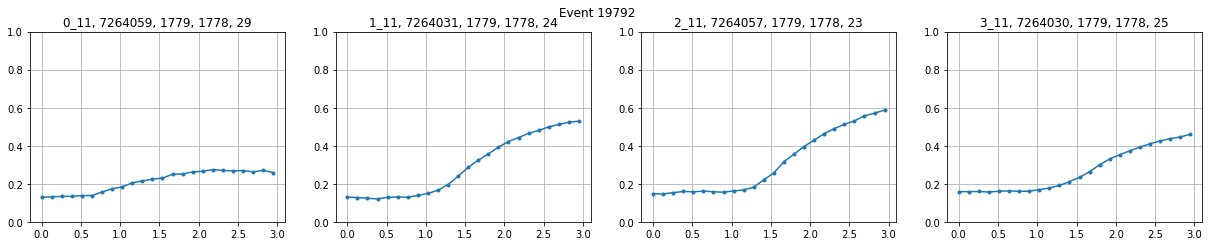

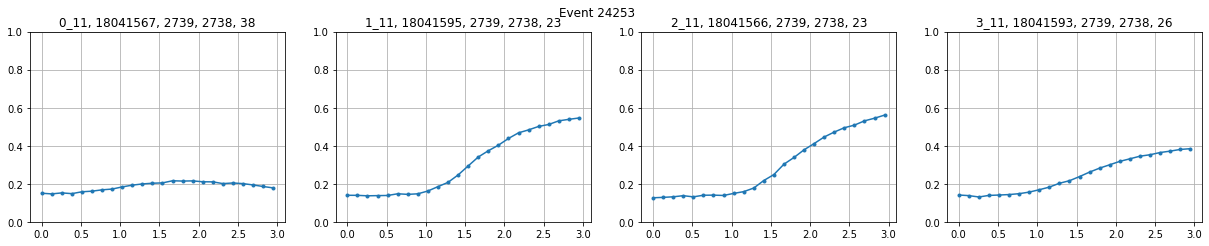

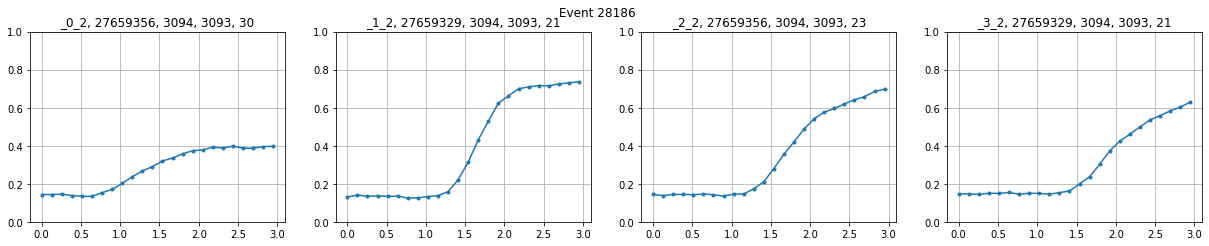

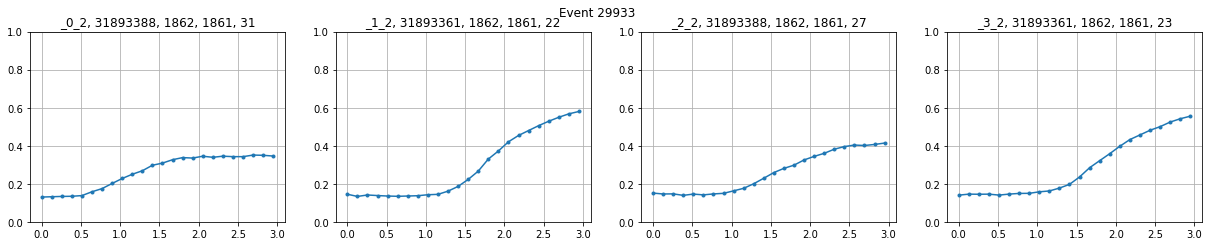

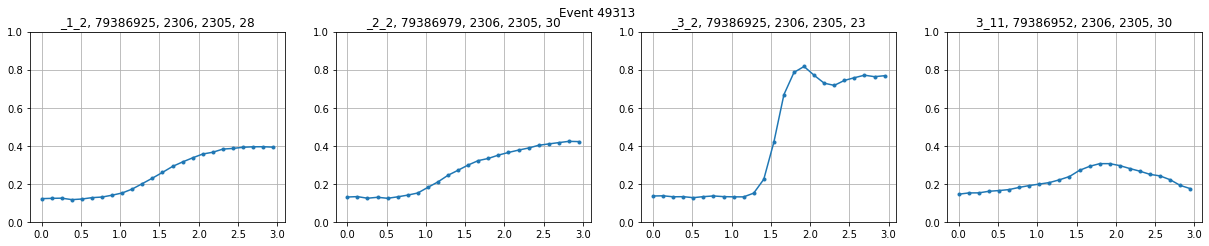

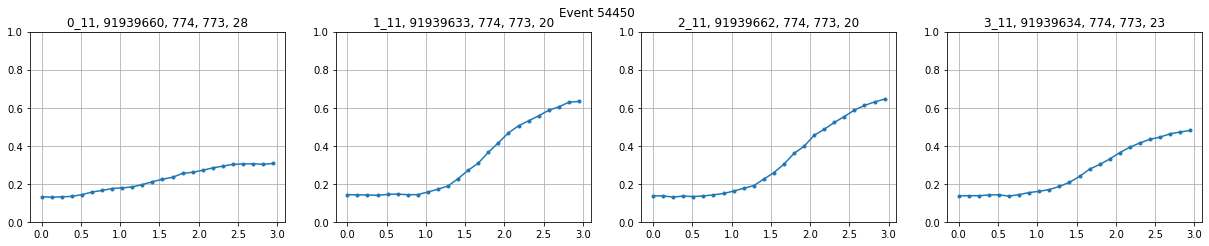

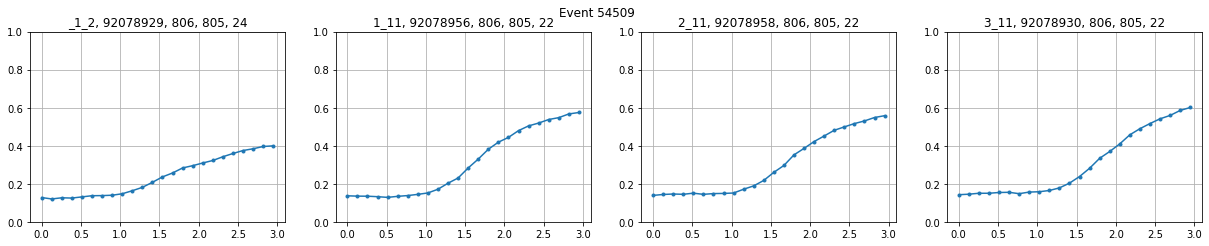

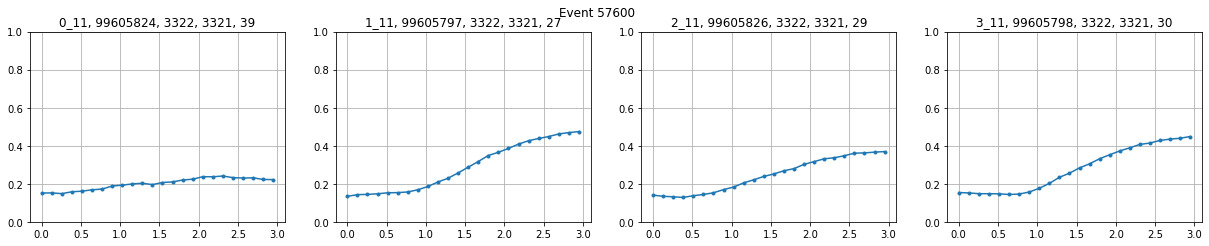

In [12]:
for event in events_to_view:
    plt.figure(figsize=(21, 3.5))
    
    for i, (det, wd) in enumerate(dataset[event].items()):
        plt.subplot(1, 4, i + 1)
        plt.plot(wd.series[0], -wd.series[1] + 1, marker='.')
        plt.title(f'{det[-6:-2]}, {wd.fpga_timestamp}, {wd.timestampA}, {wd.timestampB}, {wd.cell_info}')
        plt.ylim(0, 1)
        plt.grid()
    
    plt.suptitle(f'Event {event}')
    
    plt.show()